In [289]:
import pandas as pd
import numpy as np

"""
    Reformats date column from stock twits to the same date format as twitter
"""
def fix_date(df): 
    dx = df["Date"].apply(lambda x: x.split(" "))
    dx = dx.apply(lambda x: "{} {} {}".format(x[1][:-3], x[0], x[2])) 
    return dx 

data_names = [] # List of data frame names
file_names = [] # List of data frame names with extensions 
companies = ["MMM", "SYF", "BAYRY", "HON"] # List of 4 companies ticker symbol

"""
    Iterates through list of companies and populates data_names and file_names with strings in the format
    <company>_<year>
"""
for w in companies:
    for i in np.arange(2009,2019):
        file_names.append(w+"_"+str(i)+".csv")
        data_names.append(w+"_"+str(i))

"""
    Reads in python pickle files containing scaped posts from Stock Twits for all 4 companies as pandas DF's
    
    format
    ------
    web-scraper-order, web-scraper-start-url, Tweet, Date, Year 
"""
mmm = pd.read_pickle('3m_stocktwits.pickle', 'gzip').rename(columns = {'published_date':"Date", 'content':"Tweet"})
hon = pd.read_pickle('honeywell_stocktwits.pickle', 'gzip').rename(columns = {'published_date':"Date", 'content':"Tweet"})
syf = pd.read_pickle('synchrony_stocktwits.pickle', 'gzip').rename(columns = {'published_date':"Date", 'content':"Tweet"})
bayry = pd.read_pickle('bayer_stocktwits.pickle', 'gzip').rename(columns = {'published_date':"Date", 'content':"Tweet"})

# Reformats the dates of each dataframe
mmm["Date"] = fix_date(mmm)
hon["Date"] = fix_date(hon)
syf["Date"] = fix_date(syf)
bayry["Date"] = fix_date(bayry)


"""
    Takes in pickles as df's. Creates date column to allow for grouping by year 
    and then creates dictionaries for each years data
    
    Return
    ------
    dictionary containing dictionaries for each individual year                    
"""
def process_pickles(company_name, frame, dict_to_add):
    temp_dict = {}
    frame["Year"] = frame["Date"].apply(lambda x: x.split(" ")[2])
    years = frame["Year"].unique()
    for i in years:
        name = company_name+"_"+i
        temp = frame.groupby(['Year']).get_group(str(i))
        if int(i) != 2019:
            dict_to_add[name].append(temp[["Date", "Tweet"]])
    return dict_to_add

"""
    Read in CSV files containing scraped Twitter data for #<ticker> or $<ticker>
    saves as dictionary with the key being the name from data_names and the value being a pandas DF
"""
file_dict = {}
for file, name in zip(file_names, data_names):
    file_dict[name] = pd.read_csv(file, names = ["Date", "Tweet"])

# calls process_pickles to format 
file_dict = process_pickles("MMM", mmm, file_dict)
file_dict = process_pickles("HON", hon, file_dict)
file_dict = process_pickles("SYF", syf, file_dict)
file_dict = process_pickles("BAYRY", bayry, file_dict)

In [290]:
pre_proc = {}
count = 1;
"""
    Combines the stock twits and twitter data into single list of tweets in dictionary
"""
for key, value in file_dict.items():
    temp_dict = {}
    temp_frame = pd.DataFrame(columns = ["Tweet"])
    for index, row in value.iterrows():
        temp_dict.setdefault(row['Date'], [])
        temp_dict[row['Date']].append(row['Tweet'])              
    for keys, tweet in temp_dict.items():
        temp_frame.loc[keys] = [tweet]
    temp_frame = temp_frame.reset_index()
    temp_frame.rename(columns = {"index": "Date", "Tweet":"Tweet"}, inplace = True)
    temp_frame.sort_values(by=['Date'])
    pre_proc[key] = temp_frame

In [291]:
"""
    Create list of all dates in the year by initializing a dictionary of month keys and their corresponding length
    Added those to an empty dictionary in format <day> <month> <year>
"""
dates = np.arange(1,32)
feb = np.arange(1, 29)
months = {"Jan": 31, "Feb":28, "Mar":31, "Apr":30, "May":31, "Jun":30, "Jul":31, "Aug":31, "Sep":30, "Oct": 31, "Nov":30, "Dec":31}
index_dict = {}
for k, v in months.items():
    for j in range(1,v+1):
            key = str(j) + " " + k
            index_dict[key] = len(index_dict.keys())+1
            
"""
    converts dictionary to pandas data frame and returns frame
"""
def make_df(stack, key):
    temp = {}
    year = key.split("_")[-1]
    data = [(t+" "+str(year)) for t in index_dict.keys()]
    for i in data: 
        temp[i] = ""
    return temp

"""
    adds out of order tweets to dictionary containing all the dates in a year
"""
final_proc = {}
for k, v in pre_proc.items():
    temp = make_df(v, k)
    for indx, val in v.iterrows():
        temp[val["Date"]] = val["Tweet"]
    out = pd.DataFrame(columns = {"Date", "Tweet"})
    out["Date"] = temp.keys()
    out["Tweet"] = list(temp.values())
    final_proc[k] = out


In [150]:
"""
    convert date format to pandas readable format
"""
def convert_dates(stack):
    for i, v in stack.items():
        v['Date'] = pd.to_datetime(v['Date'], dayfirst = True)
    return stack

In [292]:
import re
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    return text.strip()
"""
    cleans each tweet using regex above
"""
for key, value in final_proc.items():
    for idx, txt in value.iterrows():
        txt["Tweet"] = [preprocess_text(t) for t in txt["Tweet"]]

final_proc = convert_dates(final_proc)

<input>:3: DeprecationWarning:

invalid escape sequence \.

<input>:4: DeprecationWarning:

invalid escape sequence \s

<input>:3: DeprecationWarning:

invalid escape sequence \.

<input>:4: DeprecationWarning:

invalid escape sequence \s

<input>:3: DeprecationWarning:

invalid escape sequence \.

<input>:4: DeprecationWarning:

invalid escape sequence \s

<ipython-input-292-c31a6ee32950>:3: DeprecationWarning:

invalid escape sequence \.

<ipython-input-292-c31a6ee32950>:4: DeprecationWarning:

invalid escape sequence \s



In [10]:
"""
    Reads in twitter sentiment training data as a pandas data frame (1.56 million tweets)
    
    Soruce
    ------
    https://www.kaggle.com/ywang311/twitter-sentiment/version/1
"""
n = ['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText']
raw_data = pd.read_csv('Sentiment Analysis Dataset 2.csv', names=n, header = 0, usecols=['Sentiment', 'SentimentText'])

In [11]:
"""
    Splits data based on sentiment (1 being positive, 0 being negative)
    Finds the one with the smallest number of tweets and concantonates a numpy array containing the subset
    Creates a labels array of 1's and 0's corresponding to the tweets in the array
"""
neg, pos = raw_data.groupby('Sentiment')
neg_c = raw_data.Sentiment.value_counts()
sample_size = int(min(neg_c[0], neg_c[1]))
raw_data = np.concatenate((neg[1].values[:sample_size], pos[1].values[:sample_size]), axis=0)
labels = [1]*sample_size + [0]*sample_size

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

"""
    Sets model and hyper parameters for natural language processing
"""
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}
"""
    preprocesses the training data to optimize learning
"""
data = [preprocess_text(t[1]) for t in raw_data]

In [14]:
"""
    splits training data and testing data randomly using sklearn method 
"""
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

520368


In [15]:
"""
    Exhaustive search over specified parameter values for an estimator 
"""
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=3, verbose = 100)
clf.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] clf__alpha=1, tfidf__norm=l1, tfidf__use_idf=True, vect__ngram_range=(1, 1) 
[CV]  clf__alpha=1, tfidf__norm=l1, tfidf__use_idf=True, vect__ngram_range=(1, 1), score=0.7769849134932376, total=  17.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.1s remaining:    0.0s
[CV] clf__alpha=1, tfidf__norm=l1, tfidf__use_idf=True, vect__ngram_range=(1, 1) 
[CV]  clf__alpha=1, tfidf__norm=l1, tfidf__use_idf=True, vect__ngram_range=(1, 1), score=0.776203402921333, total=  17.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.1s remaining:    0.0s
[CV] clf__alpha=1, tfidf__norm=l1, tfidf__use_idf=True, vect__ngram_range=(1, 1) 
[CV]  clf__alpha=1, tfidf__norm=l1, tfidf__use_idf=True, vect__ngram_range=(1, 1), score=0.7765463544284388, total=  17.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[CV] clf__alpha=1, tfidf__norm=l1, tfidf__use_idf=True, vect__ngram_range=(1, 2) 
[C

[CV]  clf__alpha=1, tfidf__norm=l2, tfidf__use_idf=False, vect__ngram_range=(1, 1), score=0.7809136006496917, total=  18.4s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 27.1min remaining:    0.0s
[CV] clf__alpha=1, tfidf__norm=l2, tfidf__use_idf=False, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=1, tfidf__norm=l2, tfidf__use_idf=False, vect__ngram_range=(1, 2), score=0.7984036073589669, total=  52.4s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 28.4min remaining:    0.0s
[CV] clf__alpha=1, tfidf__norm=l2, tfidf__use_idf=False, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=1, tfidf__norm=l2, tfidf__use_idf=False, vect__ngram_range=(1, 2), score=0.7976249971604461, total=  51.4s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 29.6min remaining:    0.0s
[CV] clf__alpha=1, tfidf__norm=l2, tfidf__use_idf=False, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=1, tfidf__norm=l2, tfidf__use_idf=False, vect__ngram_range=(1, 2), score=0.798311596486894, total=  53.4s
[Parallel(n_jobs

[CV] clf__alpha=0.1, tfidf__norm=l2, tfidf__use_idf=True, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=0.1, tfidf__norm=l2, tfidf__use_idf=True, vect__ngram_range=(1, 2), score=0.7875019876876945, total= 1.1min
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed: 55.8min remaining:    0.0s
[CV] clf__alpha=0.1, tfidf__norm=l2, tfidf__use_idf=True, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=0.1, tfidf__norm=l2, tfidf__use_idf=True, vect__ngram_range=(1, 2), score=0.7878676877731303, total= 1.0min
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 57.4min remaining:    0.0s
[CV] clf__alpha=0.1, tfidf__norm=l2, tfidf__use_idf=True, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.1, tfidf__norm=l2, tfidf__use_idf=True, vect__ngram_range=(2, 2), score=0.7688581334529728, total=  45.6s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed: 58.4min remaining:    0.0s
[CV] clf__alpha=0.1, tfidf__norm=l2, tfidf__use_idf=True, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.1, tfidf__norm=l2, tfidf__use_

[CV] clf__alpha=0.01, tfidf__norm=l1, tfidf__use_idf=False, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=0.01, tfidf__norm=l1, tfidf__use_idf=False, vect__ngram_range=(1, 2), score=0.7966050197775487, total=  52.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed: 82.8min remaining:    0.0s
[CV] clf__alpha=0.01, tfidf__norm=l1, tfidf__use_idf=False, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.01, tfidf__norm=l1, tfidf__use_idf=False, vect__ngram_range=(2, 2), score=0.7734809139929977, total=  38.8s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed: 83.7min remaining:    0.0s
[CV] clf__alpha=0.01, tfidf__norm=l1, tfidf__use_idf=False, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.01, tfidf__norm=l1, tfidf__use_idf=False, vect__ngram_range=(2, 2), score=0.7732701437950069, total=  38.6s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed: 84.6min remaining:    0.0s
[CV] clf__alpha=0.01, tfidf__norm=l1, tfidf__use_idf=False, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.01, tfidf__norm=

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': [1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)

In [16]:
"""
    return classification report showing how well our model predicted sentiment 
"""
print(classification_report(y_test, clf.predict(x_test), digits=4))    

             precision    recall  f1-score   support

          0     0.8209    0.7777    0.7987    260642
          1     0.7881    0.8297    0.8084    259726

avg / total     0.8045    0.8036    0.8035    520368



In [18]:
"""
    Due to long run time, model is saved to a pickle 
"""
import pickle
model = "grid.sav"
pickle.dump(clf, open(model, "wb"))

In [312]:
from scipy import stats
import matplotlib.pyplot as plt
"""
    Iterates through our twitter and stock twits data and predicts the sentiment based on our model
    It them averages across all tweets for said day
"""
for i, v in final_proc.items():
    emot = []
    for index, val in v.iterrows():
        if len(val["Tweet"]) != 0:
            emot.append([clf.predict(t) for t in [val["Tweet"]]])
        else:
            emot.append(np.NaN)
    v["emot"] = emot
    v["mean"] = [np.mean(t) for t in emot]

In [327]:
"""
    Combines individual years for a company into a single ordered time series data set
"""
company_stack = {}
for name in companies:
    frames = []
    for key in data_names:
        if(name == key.split("_")[0]):
            frames.append(key)
    frames.sort()
    stacked = [final_proc[t].groupby(final_proc[t]["Date"].dt.year).get_group(int(t.split("_")[1])) for t in frames]
    company_stack[name] = pd.concat(stacked)
    company_stack[name].reset_index(inplace = True)

MMM
['MMM_2009', 'MMM_2010', 'MMM_2011', 'MMM_2012', 'MMM_2013', 'MMM_2014', 'MMM_2015', 'MMM_2016', 'MMM_2017', 'MMM_2018']
SYF
['SYF_2009', 'SYF_2010', 'SYF_2011', 'SYF_2012', 'SYF_2013', 'SYF_2014', 'SYF_2015', 'SYF_2016', 'SYF_2017', 'SYF_2018']
BAYRY
['BAYRY_2009', 'BAYRY_2010', 'BAYRY_2011', 'BAYRY_2012', 'BAYRY_2013', 'BAYRY_2014', 'BAYRY_2015', 'BAYRY_2016', 'BAYRY_2017', 'BAYRY_2018']
HON
['HON_2009', 'HON_2010', 'HON_2011', 'HON_2012', 'HON_2013', 'HON_2014', 'HON_2015', 'HON_2016', 'HON_2017', 'HON_2018']


In [328]:
"""
    Twitter advanced search has a bug that retuns the December 31st of the year before the year you are querying
"""
# final_proc["HON_2016"].drop(final_proc["HON_2016"].index[365], inplace=True)
print(len(final_proc["HON_2016"]))
# final_proc["HON_2017"].drop(final_proc["HON_2017"].index[365], inplace=True)
print(len(final_proc["HON_2017"]))
# final_proc["HON_2018"].drop(final_proc["HON_2018"].index[365], inplace=True)
print(len(final_proc["HON_2018"]))

365
365
365


In [445]:
"""
    Reads in histroical stock data for each company and sets up the time series model for each 
"""
df_HON=pd.read_csv('./Data_Given/HON.csv')
df_SYF=pd.read_csv('./Data_Given/SYF.csv')
df_MMM=pd.read_csv('./Data_Given/MMM.csv')
df_BAYRY=pd.read_csv('./Data_Given/BAYZF.csv')

df_HON['datetime'] = pd.to_datetime(df_HON['Date'])
df_HON = df_HON.set_index('datetime')
df_HON.drop(['Date'], axis=1, inplace=True)
df_HON["scaled"]= df_HON["Close"]/100

df_SYF['datetime'] = pd.to_datetime(df_SYF['Date'])
df_SYF = df_SYF.set_index('datetime')
df_SYF.drop(['Date'], axis=1, inplace=True)
df_SYF["scaled"]= df_SYF["Close"]/100

df_MMM['datetime'] = pd.to_datetime(df_MMM['Date'])
df_MMM = df_MMM.set_index('datetime')
df_MMM.drop(['Date'], axis=1, inplace=True)
df_MMM["scaled"]= df_MMM["Close"]/100

df_BAYRY['datetime'] = pd.to_datetime(df_BAYRY['Date'])
df_BAYRY = df_BAYRY.set_index('datetime')
df_BAYRY.drop(['Date'], axis=1, inplace=True)
df_BAYRY["scaled"]= df_BAYRY["Close"]/100

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame


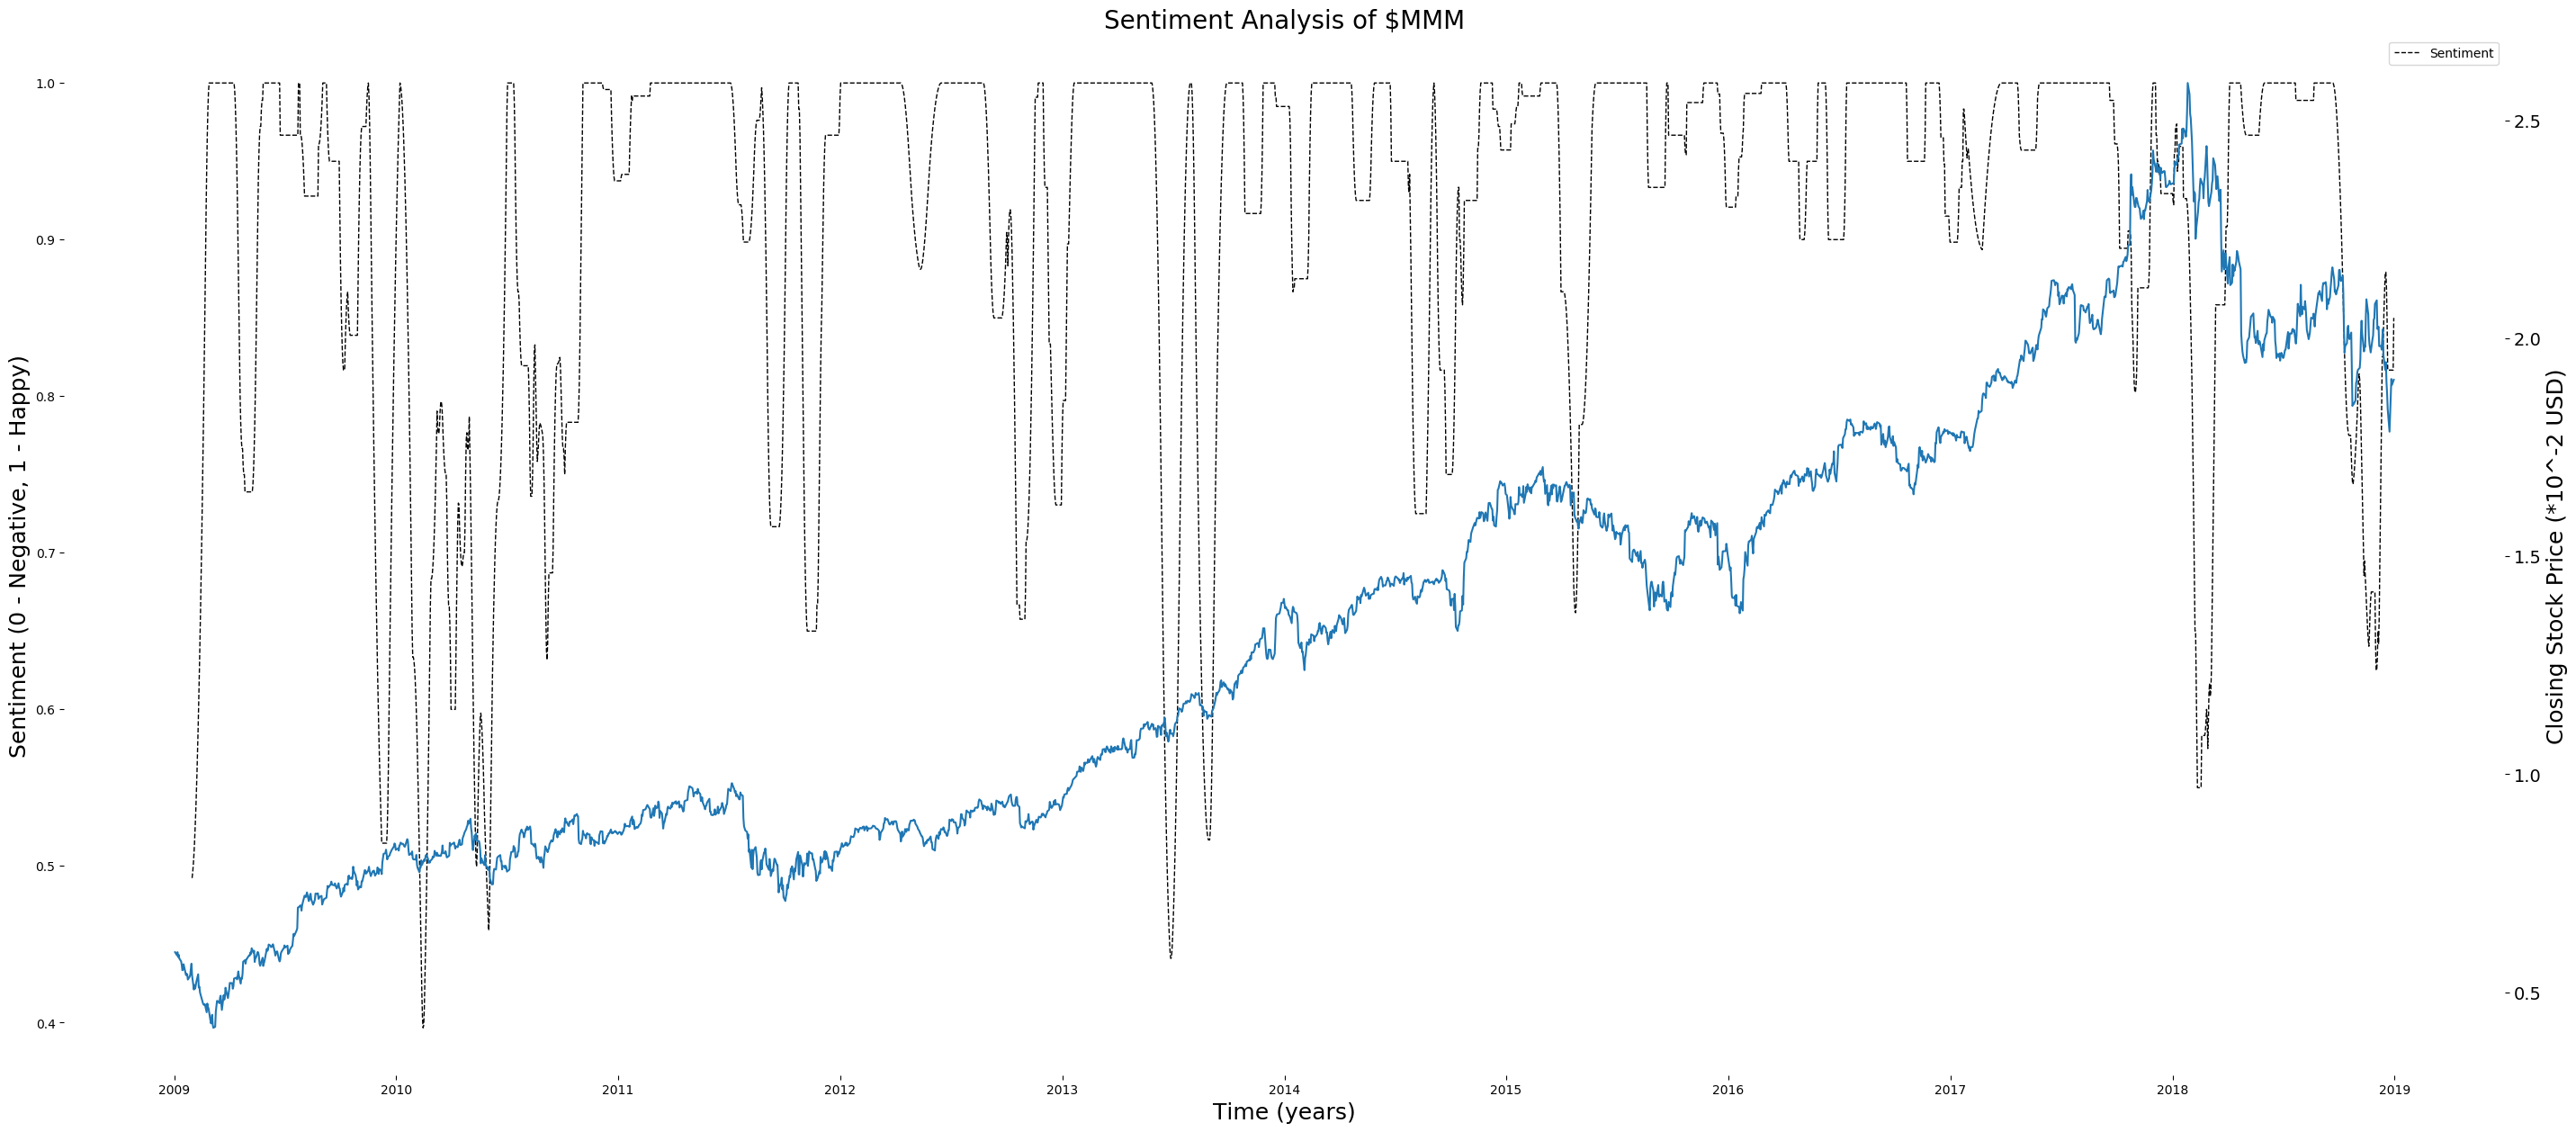

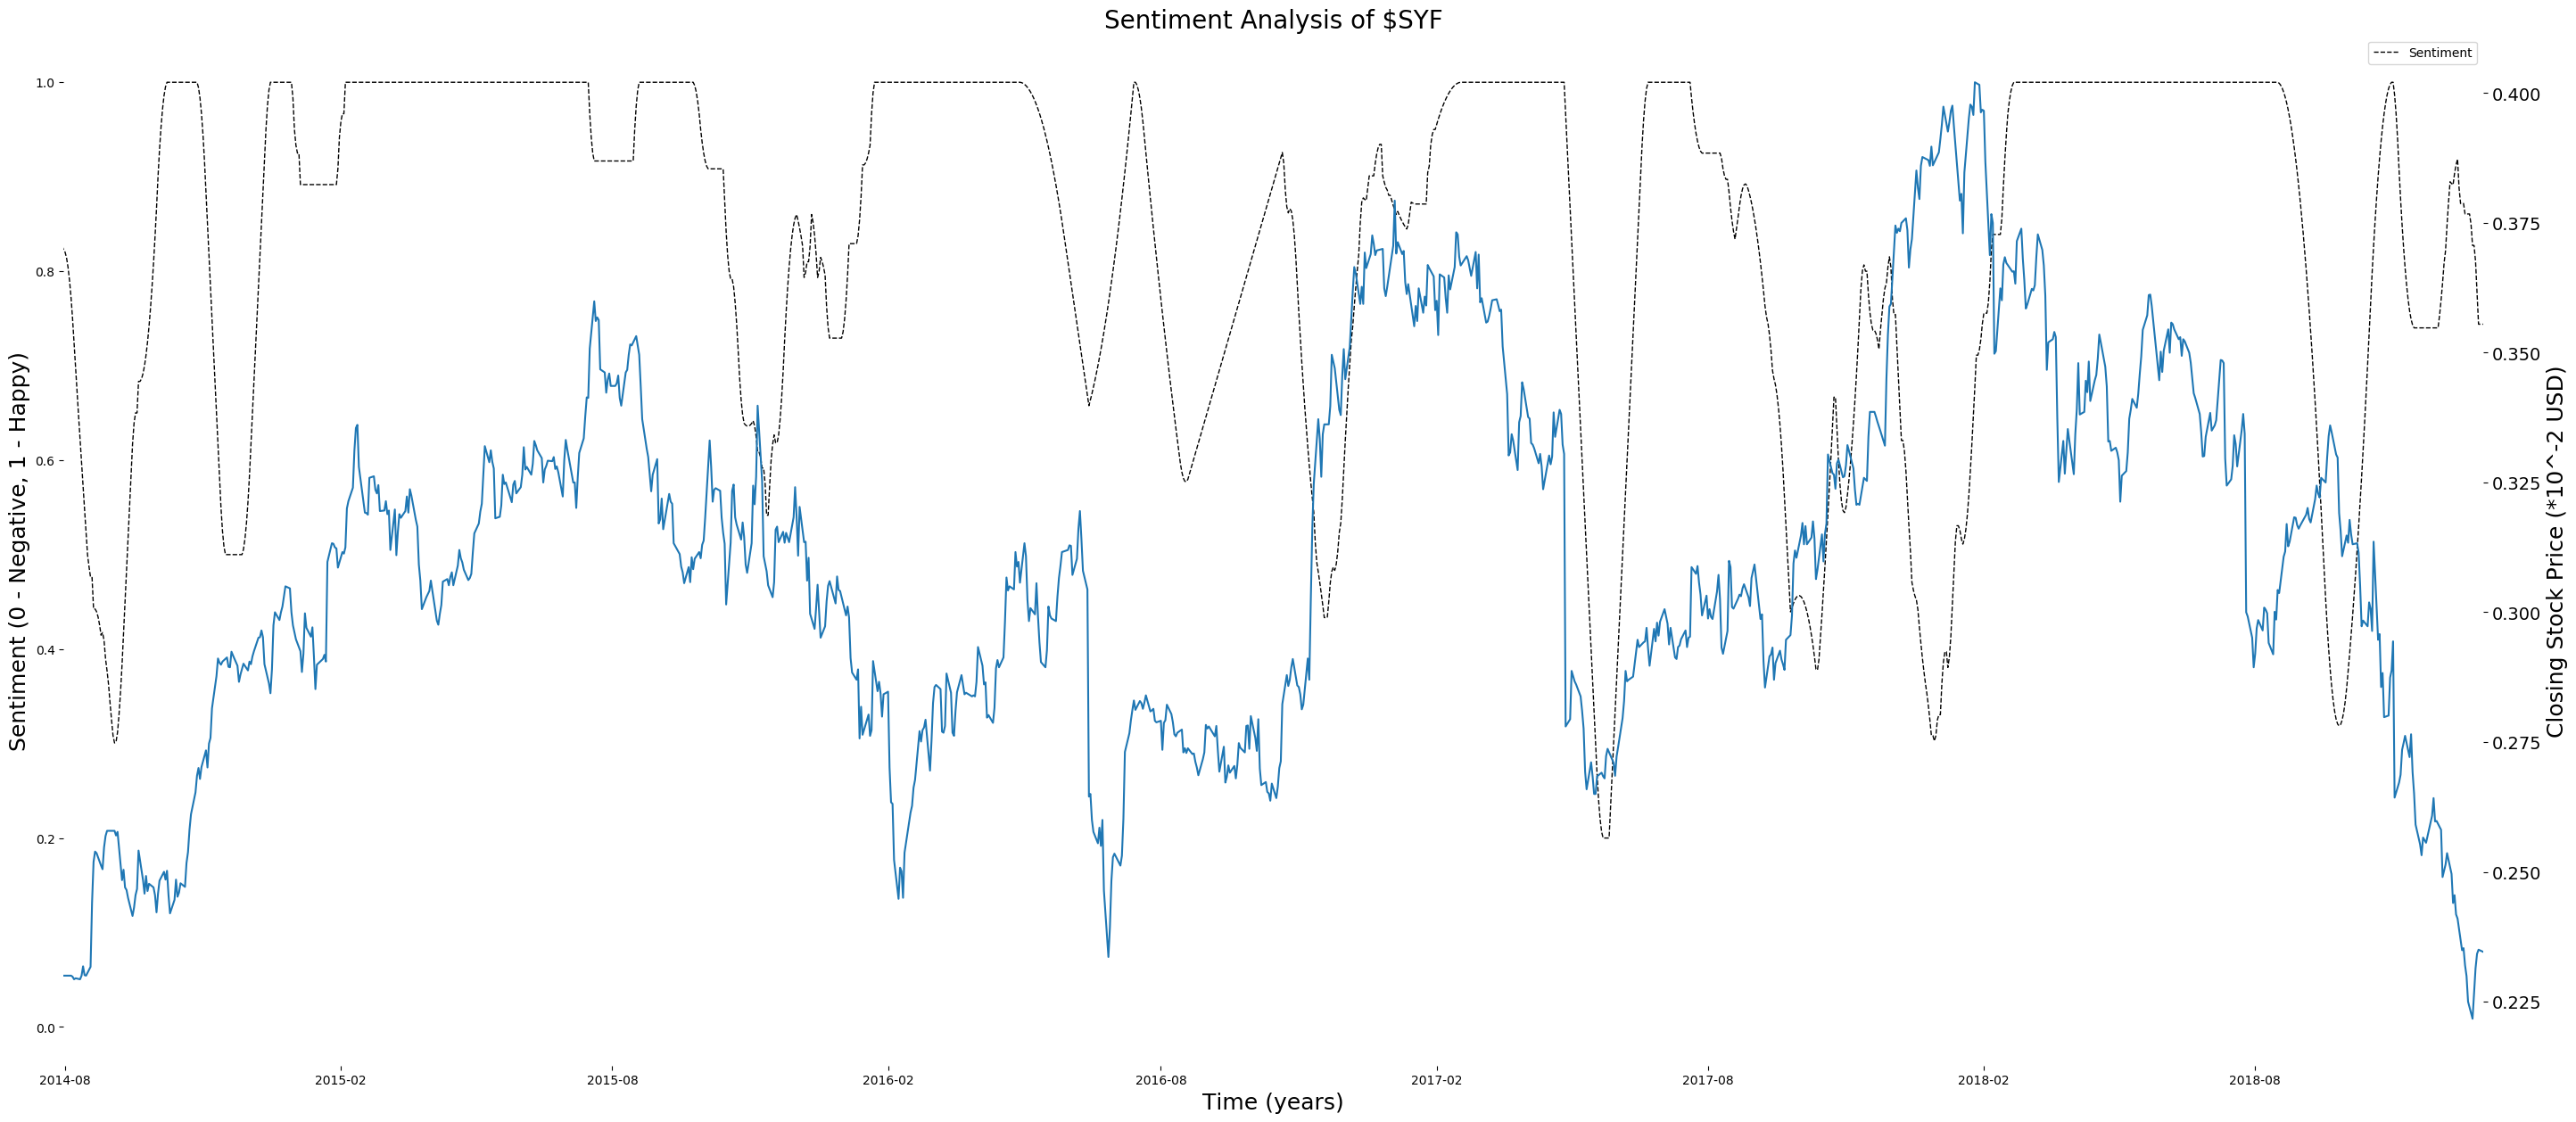

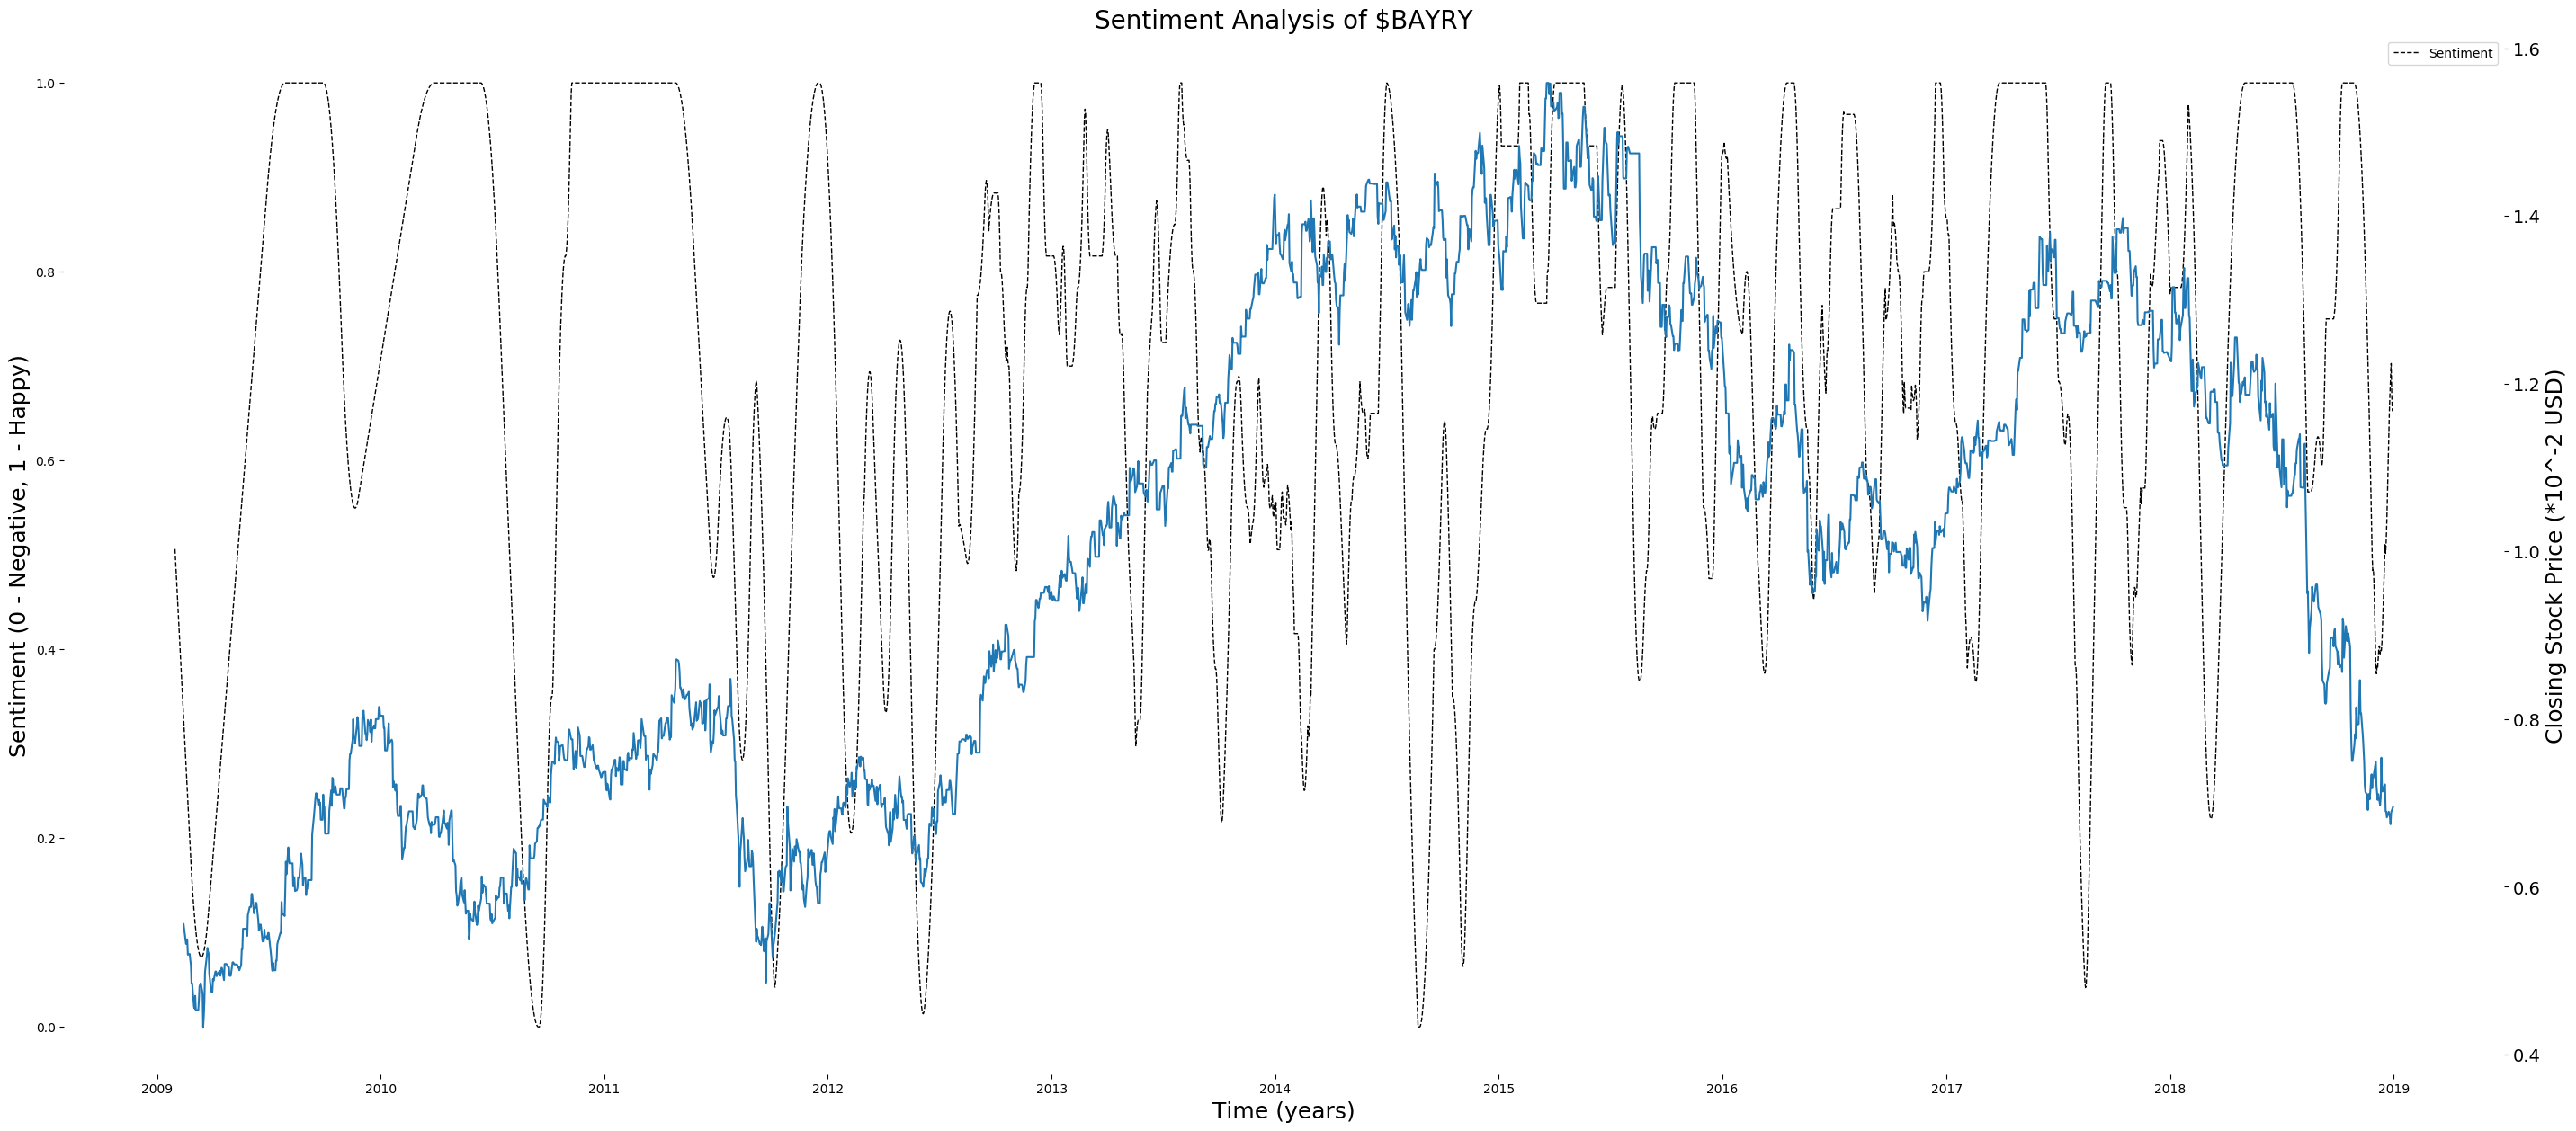

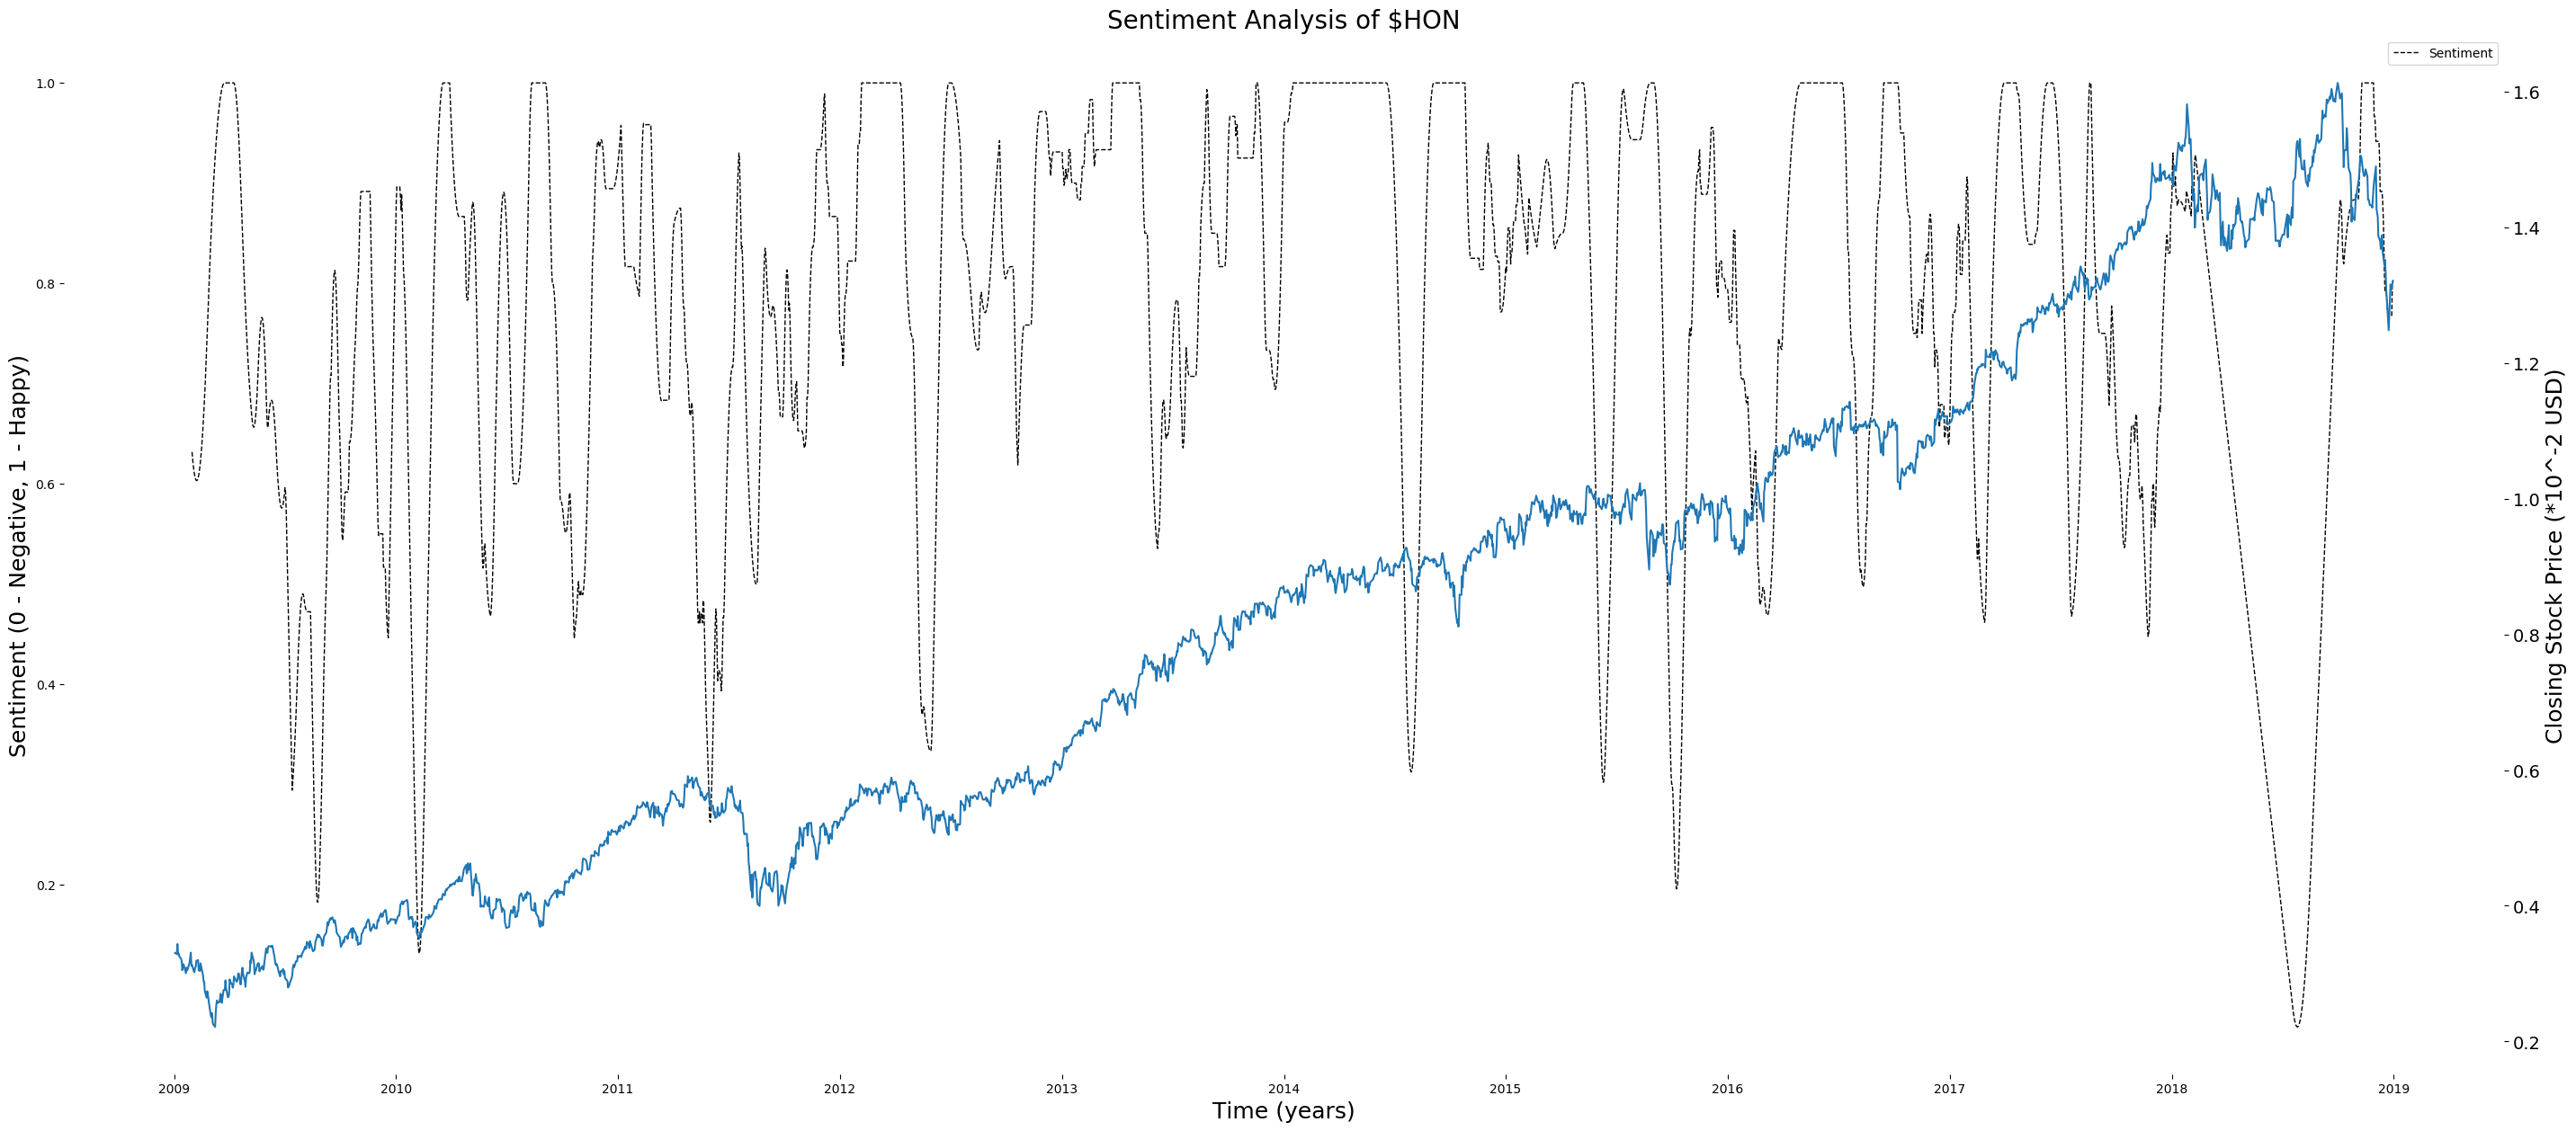

In [477]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime

"""
    Graphs sentiment data vs scaled stock data 
"""
for i, v in company_stack.items():
    v["test"] = v["mean"]
    v["test"][0] = np.mean(v["mean"].dropna())
    v["test2"] = v["test"].interpolate() 
    v["w_no_imputation"] = v["test2"].rolling(window = 30).mean()
    v["w_no_imputation"]=  v["w_no_imputation"].apply(lambda x: abs(x-1))

# temp['MA'] = temp["mean"].rolling(window=10).mean()
companies_frames = {"MMM":df_MMM, "SYF":df_SYF, "BAYRY": df_BAYRY, "HON":df_HON}

for company, frame in companies_frames.items(): 
    plt.figure(figsize=(35, 15))    
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  
    ax2 = ax.twinx()
    ax2.spines["top"].set_visible(False)    
    ax2.spines["bottom"].set_visible(False)    
    ax2.spines["right"].set_visible(False)    
    ax2.spines["left"].set_visible(False) 
    plt.yticks(fontsize=14)    
    plt.xticks(fontsize=14)
    ax.set_title( 'Sentiment Analysis of ${}'.format(company), fontsize = 20)
    ax.set_xlabel('Time (years)', fontsize=18)
    ax.set_ylabel('Sentiment (0 - Negative, 1 - Happy)', fontsize=18)
    company_frame = "df_"+company
    ax2.plot(frame["scaled"], label = "Stock Price")
    if(company == "SYF"):
        ax.set_xlim([datetime.date(2014, 7, 31), datetime.date(2018, 12, 31)])
    ax.plot(temp["Date"], company_stack[str(company)]["w_no_imputation"], "--", lw=1, color="black", alpha=1, label = "Sentiment")
    ax2.set_ylabel('Closing Stock Price (*10^-2 USD)', fontsize=18)
    ax.legend(loc='best')
    plt.savefig(company+'.png', bbox_inches='tight')

#     ax2.legend(['Stock Price'])
    plt.show()
